In [1]:
%pip install torchbnn


[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
# import scipy.stats as st
import torchbnn as bnn
import torch.nn as nn
import seaborn as sns
import pandas as pd
import numpy as np

import itertools
import warnings
import torch

from torch.utils.data import DataLoader, TensorDataset, Dataset
from copy import deepcopy

from wave_generator import WaveGen

In [3]:
# def torch_train_test_timesplit(*tensors, start_idx=None, split=.8, size=1000):
#     # if start_idx is None, generate random start
#     train_size = int(split * size) if isinstance(split, float) else split
#     test_size = size - train_size

#     data_tensors = list()
#     for tensor in tensors:
#         start_idx = torch.randint(0, tensor.shape[0] - size, 1) if start_idx is None else start_idx
#         assert start_idx < tensor.shape[0] - size, f'Start index {start_idx} is too large for size {tensor.shape[0]} tensor with full size of {size}'
#         train_indices = torch.linspace(start_idx, train_size + start_idx, train_size)
#         test_indices = torch.linspace(train_size + start_idx, test_size + train_size + start_idx, test_size)
#         train_data = tensor[train_indices]
#         test_data = tensor[test_indices]
#         data_tensors.extend((train_data, test_data))
#     return data_tensors
   
class TorchTimesplitDataset(Dataset):
    def __init__(self, signal_tensor, split=990, size=1000):
        if signal_tensor.dim() == 2:
            assert signal_tensor.shape[1] == 1
            self._signal = signal_tensor
        elif signal_tensor.dim() == 1:
            self._signal = signal_tensor.unsqueeze(dim=-1)
        else:
            raise ValueError('Expected 2 dimensional tensor with last dimension shape of 1')
        self.train_size = int(split * size) if 0 < split < 1 else int(split)
        self.test_size = int(size) - self.train_size
        self._size = int(size)
        return
    
    @property
    def shape(self):
        return int(self._signal.shape[0] - self._size),

    def __len__(self):
        return int(self._signal.shape[0] - self._size)

    def __getitem__(self, start_idx):
        in_indices = torch.linspace(start_idx, self.train_size + start_idx, self.train_size, dtype=torch.int)
        forward_indices = torch.linspace(self.train_size + start_idx, self.test_size + self.train_size + start_idx, self.test_size, dtype=torch.int)
        in_sample_data = self._signal[in_indices]
        forward_sample_data = self._signal[forward_indices]
        return in_sample_data.squeeze(), forward_sample_data.squeeze()

(500,)


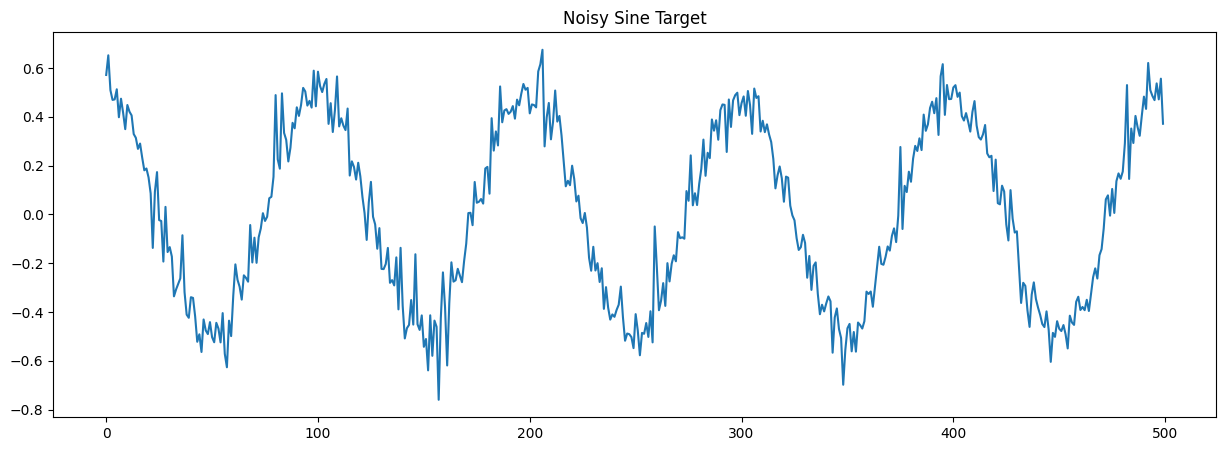

In [4]:
large_wave = WaveGen(size=500).linear_phase().cos().amp(.5).t_noise(std=.05, dof=3).sample(1).samples.squeeze(axis=0)
print(large_wave.shape)
plt.figure(figsize=(15,5))
plt.plot(large_wave)
plt.title('Noisy Sine Target')
plt.show()

In [5]:
# https://jamesmccaffrey.wordpress.com/2021/08/30/an-example-of-a-bayesian-neural-network-using-pytorch/bayesian_neural_network_demo/
class SineBayesianRegressor(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, prior_mu=0, prior_sigma=.1):
        super(SineBayesianRegressor, self).__init__()
        self.input = bnn.BayesLinear(prior_mu=prior_mu, prior_sigma=prior_sigma, in_features=input_size, out_features=hidden_size)
        self.output = bnn.BayesLinear(prior_mu=prior_mu, prior_sigma=prior_sigma, in_features=hidden_size, out_features=output_size)
        return
        
    def forward(self, x):
        x = self.input(x)
        x = torch.relu(x)
        x = self.output(x)
        return x

In [6]:
def train(
    model, 
    dataset,
    n_epochs=1000,
    batch_size=64,
    criterion=torch.nn.MSELoss(),
    optimizer=torch.optim.RMSprop,
    early_stop_patience=0,
    test_full=True,
    print_=False,
):
    optimizer = optimizer(model.parameters())
    dataloader = DataLoader(dataset, batch_size=int(batch_size), shuffle=True)
    if early_stop_patience:
        patience = 0
        model_buffer = None
        loss_buffer = torch.tensor(float('inf'))

    items = list()
    for epoch in range(n_epochs):
        for train_sample, test_sample in dataloader:
            optimizer.zero_grad()
            sample = model(train_sample)
            
            loss = criterion(sample, test_sample)       
            loss.backward()
            optimizer.step()

#             test_output = model(test_original)
#             test_loss = criterion(test_output, test_denoised)

#             if p and not epoch % 10:
#                 print('Train Loss', train_loss.item())
#                 print('Test Loss', test_loss.item())
#                 p = False
                
#         if test_full:
#             train_original, train_denoised = train_dataset[:]
#             test_original, test_denoised = test_dataset[:]
#             train_output = model(train_original)
#             train_loss = criterion(train_output, train_denoised)
#             test_output = model(test_original)
#             test_loss = criterion(test_output, test_denoised)
#             if early_stop_patience:
#                 if test_loss > loss_buffer:
#                     patience += 1
#                     if patience >= early_stop_patience:
#                         items = items[:-early_stop_patience]
#                         model = model_buffer
#                         break
#                 else:
#                     model_buffer = model
#                     loss_buffer = test_loss
#         elif early_stop_patience:
#             warnings.warn('Early Stopping Patience argument unused, full data evaluation at end of epochs is disabled. \n Set test_full to True for early stopping.')
        
        items.append(loss.item())
    return model, items

def plot_loss(loss, title='', step=1):
    plt.figure(figsize=(16,8))
    colors = sns.color_palette('Spectral', 8)
    sns.lineplot(loss[::step], dashes=False, color=colors[0], label='Train MSE')
    if title:
        plt.title(title)
    plt.legend()
    plt.show()
    return

In [7]:
input_sizes = [64,128,192]
sizes = [128,192,256]
hidden_sizes = [2, 4, 8, 16, 32, 64, 96, 128]

columns = ['input_size','output_size','hidden_size','loss']
total_i = np.prod([len(input_sizes),len(sizes),len(hidden_sizes)])
rows = list()
n_epochs = 30
batch_size = 32
for i, (input_size, size, hidden_size) in enumerate(itertools.product(input_sizes, sizes, hidden_sizes)):
    if size <= input_size: continue
        
    print('Input Set', i + 1, 'out of', total_i, end='\n')
    print(input_size, size, hidden_size, sep='|')
    output_size = size - input_size
    
    dataset = TorchTimesplitDataset(torch.from_numpy(large_wave), split=input_size, size=size)    
    
    model = SineBayesianRegressor(
        input_size, 
        output_size, 
        hidden_size, 
        prior_mu=0, 
        prior_sigma=.1,
    ).double()
    
    try:
        model, loss = train(
            model, 
            dataset, 
            n_epochs=n_epochs, 
            batch_size=batch_size, 
            test_full=True,
            early_stop_patience=5,
        )
    except RuntimeError as re:
        warnings.warn(str(re))
        continue
        
    if not len(loss):
        print('Missing loss')
        continue
    rows.append((input_size, output_size, hidden_size, loss[-1]))

Input Set 1 out of 72
64|128|2
Input Set 2 out of 72
64|128|4
Input Set 3 out of 72
64|128|8
Input Set 4 out of 72
64|128|16
Input Set 5 out of 72
64|128|32
Input Set 6 out of 72
64|128|64
Input Set 7 out of 72
64|128|96
Input Set 8 out of 72
64|128|128
Input Set 9 out of 72
64|192|2
Input Set 10 out of 72
64|192|4
Input Set 11 out of 72
64|192|8
Input Set 12 out of 72
64|192|16
Input Set 13 out of 72
64|192|32
Input Set 14 out of 72
64|192|64
Input Set 15 out of 72
64|192|96
Input Set 16 out of 72
64|192|128
Input Set 17 out of 72
64|256|2
Input Set 18 out of 72
64|256|4
Input Set 19 out of 72
64|256|8
Input Set 20 out of 72
64|256|16
Input Set 21 out of 72
64|256|32
Input Set 22 out of 72
64|256|64
Input Set 23 out of 72
64|256|96
Input Set 24 out of 72
64|256|128
Input Set 33 out of 72
128|192|2
Input Set 34 out of 72
128|192|4
Input Set 35 out of 72
128|192|8
Input Set 36 out of 72
128|192|16
Input Set 37 out of 72
128|192|32
Input Set 38 out of 72
128|192|64
Input Set 39 out of 72

In [8]:
grid_df = pd.DataFrame(rows, columns=columns)
assert grid_df.shape[1] == len(columns), f'{grid_df.shape[1]} != {len(columns)}'
grid_df.columns = columns
grid_df.to_csv(f'training_io_{pd.to_datetime("today").strftime("%Y-%m-%d:%H")}.csv')
display(grid_df)

,input_size,output_size,hidden_size,loss
0,64,64,2,0.028560
1,64,64,4,0.017334
2,64,64,8,0.015486
3,64,64,16,0.021388
4,64,64,32,0.027651
5,64,64,64,0.017659
6,64,64,96,0.019323
7,64,64,128,0.028199
8,64,128,2,0.023532
9,64,128,4,0.018001


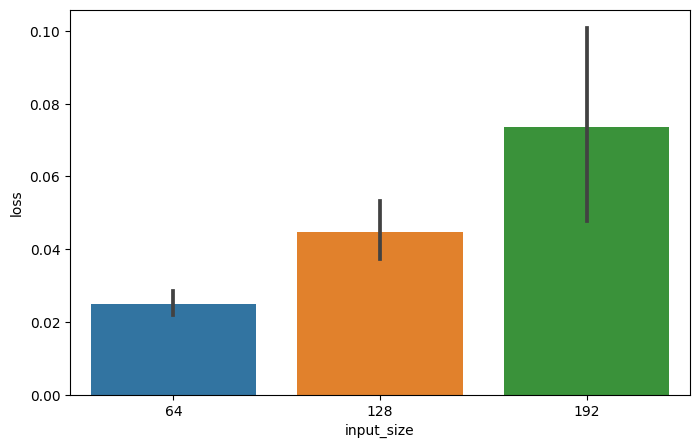

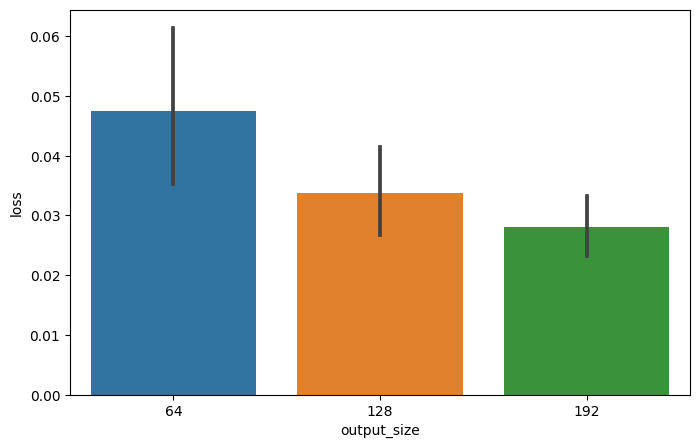

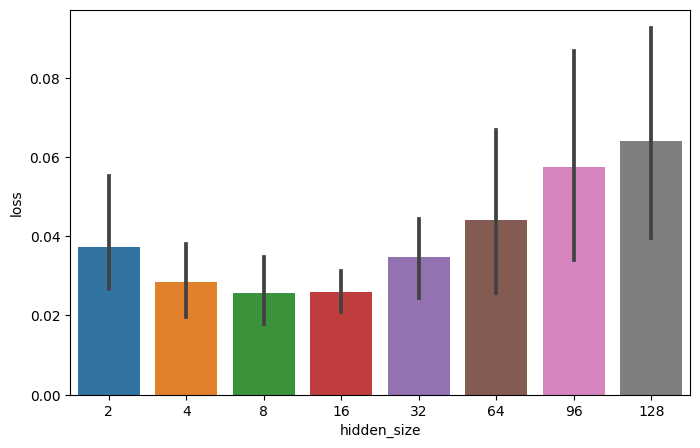

In [9]:
for col in columns[:-1]:
    plt.figure(figsize=(8,5))
    sns.barplot(data=grid_df, x=col, y='loss')
    plt.show()

In [10]:
best_param_df = grid_df.loc[grid_df['loss'].idxmin(),grid_df.columns[:-1]]
display(best_param_df)
best_input_size, best_output_size, best_hidden_size = best_param_df.to_numpy()
display(f'Best Input Size {best_input_size}', f'Best Output Size {best_output_size}', f'Best Hidden Size {best_hidden_size}')


best_dataset = TorchTimesplitDataset(torch.from_numpy(large_wave), split=best_input_size, size=best_input_size + best_output_size)    

best_model = SineBayesianRegressor(
    int(best_input_size), 
    int(best_output_size), 
    int(best_hidden_size), 
    prior_mu=0, 
    prior_sigma=.1,
).double()
    
best_model, loss = train(
    best_model, 
    best_dataset, 
    n_epochs=100, 
    batch_size=64, 
#     test_full=True,
    early_stop_patience=30,
)

input_size      64.0
output_size    128.0
hidden_size     16.0
Name: 11, dtype: float64

'Best Input Size 64.0'

'Best Output Size 128.0'

'Best Hidden Size 16.0'

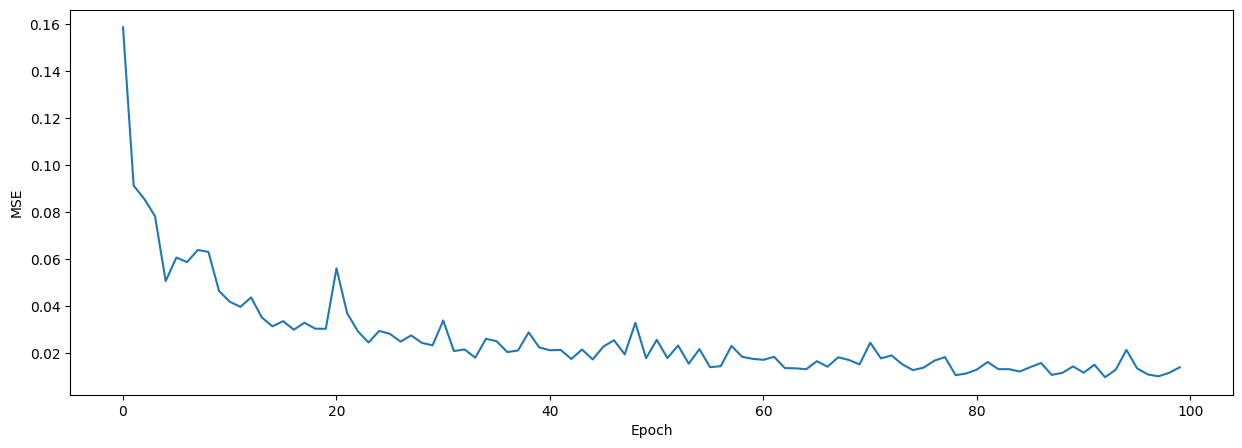

In [11]:
plt.figure(figsize=(15,5))
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

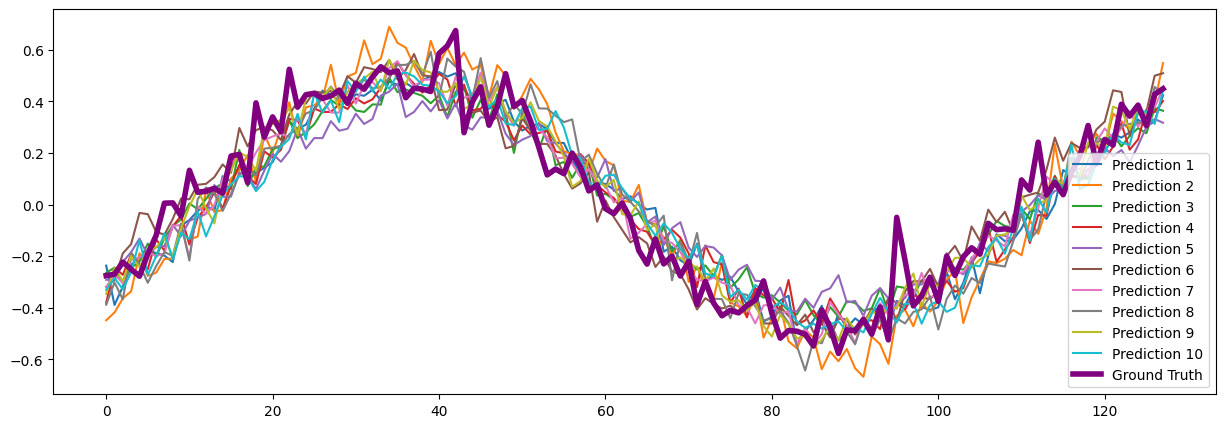

In [12]:
plt.figure(figsize=(15,5))
rand_sample_train, rand_sample_test = best_dataset[100]
for i in range(10):
    plt.plot(best_model(rand_sample_train).detach().numpy(), label='Prediction ' + str(i + 1))
plt.plot(rand_sample_test, color='purple', linewidth=4, label='Ground Truth')
plt.legend()
plt.show()